# DQN (Deep Q-Network) 深度Q网络算法

## 什么是DQN？

DQN（Deep Q-Network）是将深度学习与Q-learning相结合的强化学习算法，由DeepMind在2015年提出。它使用神经网络来近似Q函数，解决了传统Q-learning在高维状态空间中的局限性。

### 为什么需要DQN？

传统Q-learning的局限性：
1. **状态空间爆炸**：对于高维状态空间（如图像），Q表变得不可行
2. **泛化能力差**：无法处理未见过的状态
3. **连续状态问题**：无法处理连续状态空间

DQN的优势：
1. **函数逼近**：使用神经网络近似Q函数
2. **泛化能力**：能够处理相似的状态
3. **高维输入**：可以直接处理图像等高维数据
4. **端到端学习**：从原始输入直接学习策略

## DQN核心公式详解

### 1. 基本Q-learning公式回顾

传统Q-learning的更新公式：

**Q(s,a) ← Q(s,a) + α[r + γ * max Q(s',a') - Q(s,a)]**

### 2. DQN的损失函数

DQN使用神经网络Q(s,a;θ)来近似Q函数，其中θ是网络参数。损失函数为：

**L(θ) = E[(r + γ * max Q(s',a';θ⁻) - Q(s,a;θ))²]**

其中：
- θ：主网络的参数
- θ⁻：目标网络的参数
- r + γ * max Q(s',a';θ⁻)：目标值
- Q(s,a;θ)：预测值

### 3. 目标网络(Target Network)

DQN引入目标网络来解决训练不稳定的问题：

**y = r + γ * max Q(s',a';θ⁻)**

目标网络的特点：
1. 参数θ⁻定期从主网络复制
2. 在训练过程中保持不变
3. 提供更稳定的学习目标

## DQN算法核心组件详解

### 1. 经验回放(Experience Replay)

**核心思想**：存储和重用过去的经验

**实现方式**：
```
经验池 D = {(s₁,a₁,r₁,s'₁), (s₂,a₂,r₂,s'₂), ..., (sₙ,aₙ,rₙ,s'ₙ)}
```

**优势**：
1. **数据效率**：经验可以被多次使用
2. **打破相关性**：随机采样打破序列相关性
3. **稳定性**：提供更稳定的训练数据

**采样过程**：
```
从经验池D中随机采样小批量数据：
B = {(sᵢ,aᵢ,rᵢ,s'ᵢ)}ᵢ₌₁ᵐ
```

### 2. 目标网络(Target Network)

**核心思想**：使用独立的网络计算目标值

**更新机制**：
```
目标网络参数 θ⁻ ← 主网络参数 θ
更新频率：每C步同步一次
```

**优势**：
1. **训练稳定性**：避免目标值快速变化
2. **收敛性**：提供更一致的学习目标
3. **减少振荡**：防止训练过程中的剧烈波动

### 3. ε-贪心策略的改进

**线性衰减**：
```
ε = max(ε_min, ε - (ε_max - ε_min) / decay_steps)
```

**指数衰减**：
```
ε = max(ε_min, ε * decay_rate)
```

**自适应衰减**：
```
根据训练进度动态调整探索率
```

## DQN完整算法流程

### 算法步骤

1. **初始化**：
   - 初始化主网络Q(s,a;θ)和目标网络Q(s,a;θ⁻)
   - 初始化经验回放池D，容量为N
   - 初始化ε-贪心策略参数

2. **交互与学习**：
   - 对于每个episode：
     - 初始化状态s
     - 对于每个时间步：
       a. 选择动作：a = argmax Q(s,a;θ) （以1-ε概率）或随机动作（以ε概率）
       b. 执行动作a，观察奖励r和新状态s'
       c. 存储经验：(s,a,r,s') → D
       d. 从D中随机采样小批量数据
       e. 计算目标值：y = r + γ * max Q(s',a';θ⁻)
       f. 计算损失：L = (y - Q(s,a;θ))²
       g. 通过梯度下降更新主网络参数θ
       h. 每C步更新目标网络：θ⁻ ← θ
       i. s ← s'

3. **终止条件**：
   - 达到最大episode数
   - 性能收敛
   - 手动停止

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import gym
from torch.utils.tensorboard import SummaryWriter

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## DQN网络结构实现

In [8]:
class DQN(nn.Module):
    """深度Q网络"""
    def __init__(self, state_size, action_size, hidden_sizes=[128, 128]):
        super(DQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        # 构建网络层
        layers = []
        prev_size = state_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # 输出层
        layers.append(nn.Linear(prev_size, action_size))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, state):
        """前向传播"""
        return self.network(state)
    
    def get_action_values(self, state):
        """获取所有动作的Q值"""
        with torch.no_grad():
            q_values = self.forward(state)
            return q_values.cpu().numpy()
    
    def get_best_action(self, state):
        """获取最优动作"""
        q_values = self.get_action_values(state)
        return np.argmax(q_values)

## 经验回放实现

In [9]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """经验回放池"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def push(self, state, action, reward, next_state, done):
        """添加经验"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """随机采样经验"""
        batch = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([e.state for e in batch]).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(device)
        dones = torch.BoolTensor([bool(e.done) for e in batch]).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)
    
    def is_ready(self, batch_size):
        """检查是否有足够的经验"""
        return len(self.buffer) >= batch_size

## DQN智能体实现

In [10]:
class DQNAgent:
    """DQN智能体"""
    def __init__(self, state_size, action_size, learning_rate=1e-3, 
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01, 
                 epsilon_decay=0.995, buffer_size=10000, 
                 batch_size=64, target_update=100):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        
        # 初始化网络
        self.q_network = DQN(state_size, action_size).to(device)
        self.target_network = DQN(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # 优化器
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # 经验回放池
        self.memory = ReplayBuffer(buffer_size)
        
        # 训练计数
        self.update_count = 0
        
    def act(self, state, training=True):
        """选择动作"""
        if training and random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        """存储经验"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self):
        """经验回放学习"""
        if not self.memory.is_ready(self.batch_size):
            return
        
        # 采样经验
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # 计算当前Q值
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # 计算目标Q值
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # 计算损失
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # 反向传播
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 更新目标网络
        self.update_count += 1
        if self.update_count % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        return loss.item()
    
    def decay_epsilon(self):
        """衰减探索率"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath):
        """保存模型"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
        }, filepath)
    
    def load(self, filepath):
        """加载模型"""
        checkpoint = torch.load(filepath, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

## 训练环境：CartPole

In [11]:
# 创建CartPole环境
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"size of state: {state_size}")
print(f"size of action: {action_size}")
print(f"state: {env.observation_space.low} - {env.observation_space.high}")
print(f"action: {list(range(action_size))}")

size of state: 4
size of action: 2
state: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] - [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
action: [0, 1]


## 训练DQN智能体

In [14]:
def train_dqn(env, agent, episodes=1000, max_steps=500, log_interval=10):
    """训练DQN智能体"""
    
    scores = []
    losses = []
    epsilons = []
    
    print("开始训练DQN智能体...")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0
        done = False
        episode_loss = 0
        steps = 0
        
        while not done and steps < max_steps:
            # 选择动作
            action = agent.act(state)
            
            # 执行动作
            result = env.step(action)
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, done, _, _ = result
            
            # 存储经验
            agent.remember(state, action, reward, next_state, done)
            
            # 经验回放学习
            loss = agent.replay()
            if loss is not None:
                episode_loss += loss
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # 衰减探索率
        agent.decay_epsilon()
        
        # 记录数据
        scores.append(total_reward)
        epsilons.append(agent.epsilon)
        avg_loss = episode_loss / steps if steps > 0 else 0
        losses.append(avg_loss)
        
        # 打印进度
        if (episode + 1) % log_interval == 0:
            avg_score = np.mean(scores[-log_interval:])
            print(f"Episode {episode + 1}/{episodes}, "
                  f"Average Score: {avg_score:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}, "
                  f"Loss: {avg_loss:.4f}")
        
        # 检查是否解决环境
        if len(scores) >= 100 and np.mean(scores[-100:]) >= 195:
            print(f"环境在episode {episode + 1}被解决！")
            break
    
    return scores, losses, epsilons

# 创建DQN智能体
agent = DQNAgent(state_size, action_size, 
                 learning_rate=1e-3,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_decay=0.995,
                 buffer_size=10000,
                 batch_size=64,
                 target_update=100)

# 训练智能体
scores, losses, epsilons = train_dqn(env, agent, episodes=500, max_steps=500)

开始训练DQN智能体...
Episode 10/500, Average Score: 15.40, Epsilon: 0.951, Loss: 0.0016


/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_22971/3162510941.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  states = torch.FloatTensor([e.state for e in batch]).to(device)


Episode 20/500, Average Score: 23.00, Epsilon: 0.905, Loss: 0.3879
Episode 30/500, Average Score: 25.10, Epsilon: 0.860, Loss: 0.4094
Episode 40/500, Average Score: 23.40, Epsilon: 0.818, Loss: 0.6427
Episode 50/500, Average Score: 19.80, Epsilon: 0.778, Loss: 0.6702
Episode 60/500, Average Score: 32.80, Epsilon: 0.740, Loss: 0.8570
Episode 70/500, Average Score: 30.90, Epsilon: 0.704, Loss: 0.8398
Episode 80/500, Average Score: 46.30, Epsilon: 0.670, Loss: 1.9877
Episode 90/500, Average Score: 75.50, Epsilon: 0.637, Loss: 2.6312
Episode 100/500, Average Score: 62.50, Epsilon: 0.606, Loss: 3.6779
Episode 110/500, Average Score: 64.10, Epsilon: 0.576, Loss: 3.2125
Episode 120/500, Average Score: 65.80, Epsilon: 0.548, Loss: 3.2268
Episode 130/500, Average Score: 72.00, Epsilon: 0.521, Loss: 5.6887
Episode 140/500, Average Score: 38.20, Epsilon: 0.496, Loss: 7.9156
Episode 150/500, Average Score: 74.00, Epsilon: 0.471, Loss: 11.0388
Episode 160/500, Average Score: 70.10, Epsilon: 0.448, 

## 训练结果可视化

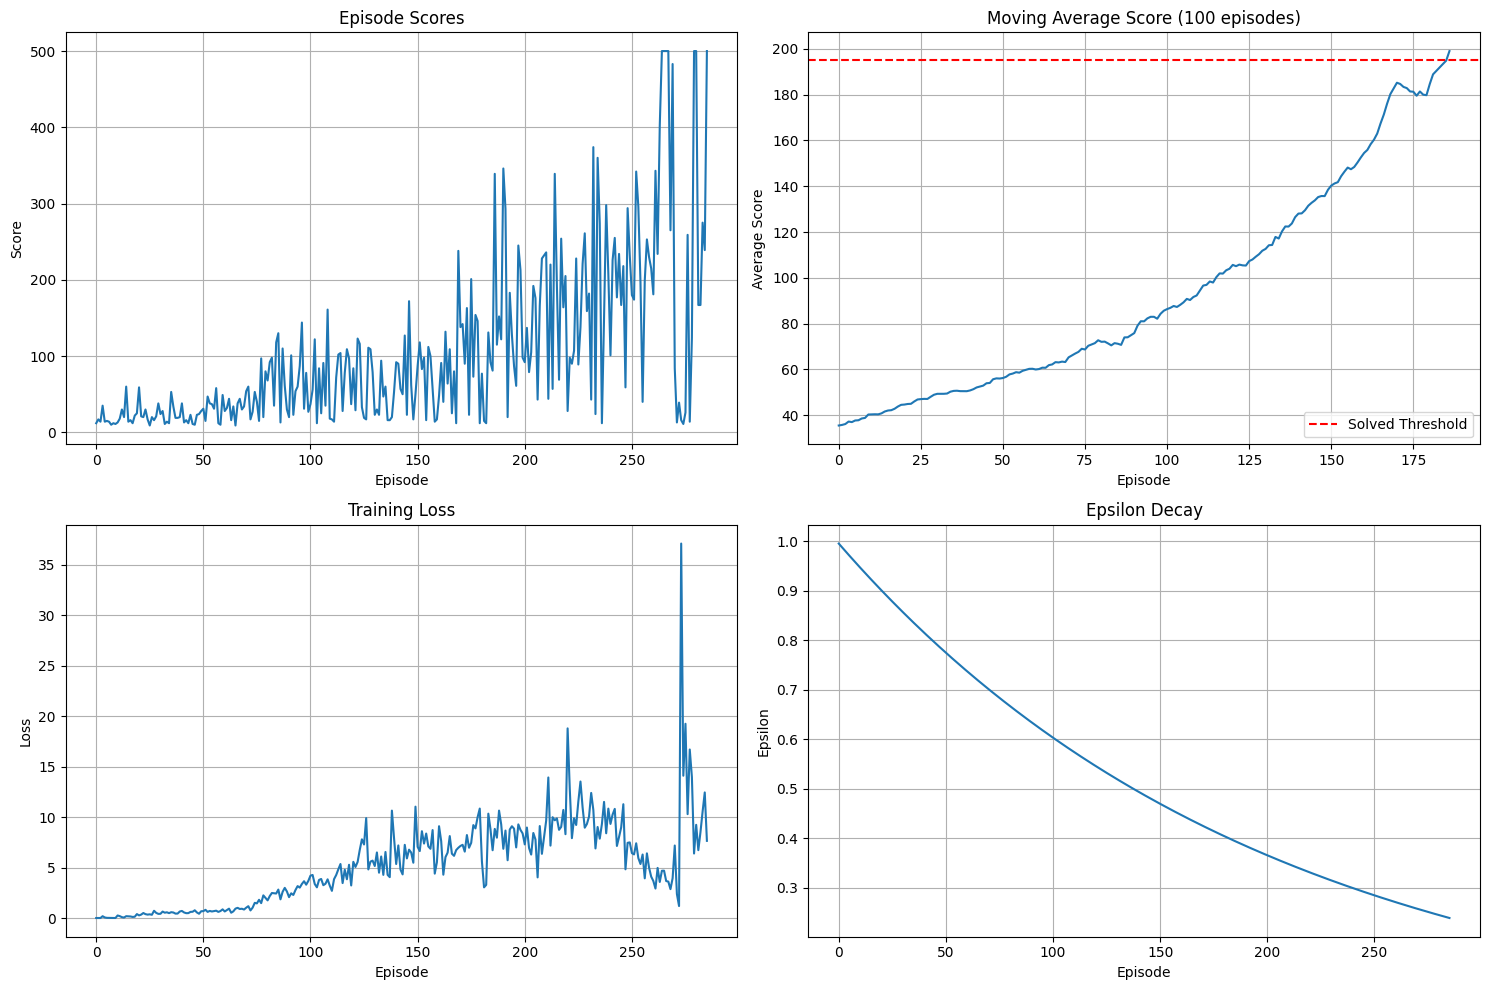

In [15]:
def plot_training_results(scores, losses, epsilons):
    """可视化训练结果"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 得分曲线
    axes[0, 0].plot(scores)
    axes[0, 0].set_title('Episode Scores')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].grid(True)
    
    # 移动平均得分
    if len(scores) >= 100:
        moving_avg = np.convolve(scores, np.ones(100)/100, mode='valid')
        axes[0, 1].plot(moving_avg)
        axes[0, 1].set_title('Moving Average Score (100 episodes)')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Average Score')
        axes[0, 1].axhline(y=195, color='r', linestyle='--', label='Solved Threshold')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # 损失曲线
    axes[1, 0].plot(losses)
    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)
    
    # 探索率衰减
    axes[1, 1].plot(epsilons)
    axes[1, 1].set_title('Epsilon Decay')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Epsilon')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 绘制训练结果
plot_training_results(scores, losses, epsilons)

## 测试训练好的智能体

In [16]:
def test_agent(env, agent, episodes=10, max_steps=500, render=True):
    """测试训练好的智能体"""
    print("测试训练好的DQN智能体:")
    
    test_scores = []
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            if render and episode == 0:  # 只渲染第一个episode
                env.render()
            
            # 使用训练好的网络选择动作（不探索）
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = agent.q_network(state_tensor)
                action = torch.argmax(q_values).item()
            
            result = env.step(action)
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, done, _, _ = result
            
            state = next_state
            total_reward += reward
            steps += 1
        
        test_scores.append(total_reward)
        print(f"Test Episode {episode + 1}: Score = {total_reward}, Steps = {steps}")
        
        if render and episode == 0:
            env.close()
    
    avg_score = np.mean(test_scores)
    print(f"\n平均测试得分: {avg_score:.2f}")
    return test_scores

# 测试智能体
test_scores = test_agent(env, agent, episodes=5, render=False)

测试训练好的DQN智能体:
Test Episode 1: Score = 500.0, Steps = 500
Test Episode 2: Score = 500.0, Steps = 500
Test Episode 3: Score = 500.0, Steps = 500
Test Episode 4: Score = 500.0, Steps = 500
Test Episode 5: Score = 500.0, Steps = 500

平均测试得分: 500.00


## DQN算法分析

In [18]:
def analyze_dqn_training():
    """分析DQN训练过程"""
    
    print("=== DQN训练分析 ===\n")
    
    print("1. 网络结构分析:")
    print("   - 输入层：状态维度 (4维)")
    print("   - 隐藏层：128 → 128 (ReLU激活)")
    print("   - 输出层：动作维度 (2维)")
    print("   - 总参数：约 4×128 + 128×128 + 128×2 = 16,640 个参数")
    
    print("\n2. 超参数设置:")
    print("   - 学习率：1e-3")
    print("   - 折扣因子：0.99")
    print("   - 探索率衰减：0.995")
    print("   - 经验池大小：10,000")
    print("   - 批量大小：64")
    print("   - 目标网络更新频率：100步")
    
    print("\n3. 性能指标:")
    if len(scores) > 0:
        print(f"   - 最终得分：{scores[-1]:.2f}")
        print(f"   - 最高得分：{max(scores):.2f}")
        print(f"   - 平均得分：{np.mean(scores):.2f}")
        if len(scores) >= 100:
            print(f"   - 最近100集平均：{np.mean(scores[-100:]):.2f}")
    
    print("\n4. 算法特点:")
    print("   ✓ 使用经验回放提高数据效率")
    print("   ✓ 目标网络提供稳定的学习目标")
    print("   ✓ ε-贪心策略平衡探索与利用")
    print("   ✓ 神经网络处理连续状态空间")
    
    print("\n5. 改进方向:")
    print("   - 使用卷积网络处理图像输入")
    print("   - 实现优先级经验回放")
    print("   - 使用双DQN减少过估计")
    print("   - 实现Dueling DQN架构")

analyze_dqn_training()

=== DQN训练分析 ===

1. 网络结构分析:
   - 输入层：状态维度 (4维)
   - 隐藏层：128 → 128 (ReLU激活)
   - 输出层：动作维度 (2维)
   - 总参数：约 4×128 + 128×128 + 128×2 = 16,640 个参数

2. 超参数设置:
   - 学习率：1e-3
   - 折扣因子：0.99
   - 探索率衰减：0.995
   - 经验池大小：10,000
   - 批量大小：64
   - 目标网络更新频率：100步

3. 性能指标:
   - 最终得分：500.00
   - 最高得分：500.00
   - 平均得分：103.79
   - 最近100集平均：199.07

4. 算法特点:
   ✓ 使用经验回放提高数据效率
   ✓ 目标网络提供稳定的学习目标
   ✓ ε-贪心策略平衡探索与利用
   ✓ 神经网络处理连续状态空间

5. 改进方向:
   - 使用卷积网络处理图像输入
   - 实现优先级经验回放
   - 使用双DQN减少过估计
   - 实现Dueling DQN架构


## DQN算法总结

### DQN的核心贡献

1. **函数逼近**：使用神经网络近似Q函数，解决高维状态空间问题
2. **经验回放**：通过经验重用提高数据效率和训练稳定性
3. **目标网络**：独立的目标网络提供更稳定的学习目标

### DQN的优势

1. **端到端学习**：从原始输入直接学习最优策略
2. **泛化能力**：能够处理相似的状态和未见过的状态
3. **可扩展性**：适用于各种复杂环境
4. **稳定性**：通过经验回放和目标网络提高训练稳定性

### DQN的局限性

1. **过估计问题**：max操作可能导致Q值过估计
2. **样本效率**：仍需要大量样本才能收敛
3. **超参数敏感**：对学习率、网络结构等超参数敏感
4. **训练不稳定**：在某些环境下可能出现训练不稳定

### DQN的改进版本

1. **Double DQN**：解决过估计问题
2. **Dueling DQN**：分离状态价值和动作优势
3. **Prioritized DQN**：优先级经验回放
4. **Rainbow DQN**：整合多种改进技术

### 应用场景

1. **游戏AI**：Atari游戏、围棋、象棋等
2. **机器人控制**：路径规划、操作控制
3. **自动驾驶**：决策制定、路径规划
4. **推荐系统**：个性化推荐
5. **金融交易**：自动交易策略